<a href="https://colab.research.google.com/github/bradlipovsky/arc/blob/master/ARC_Kalman_Filter_Synthetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
!pip install filterpy # Uncheck this the first time you run the code
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

     |████████████████████████████████| 184kB 2.9MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-cp36-none-any.whl size=110451 sha256=dd9befe4b8f22f9d123c6010ef6efcaea0268509fab95f0c1f06c4cba495158c
  Stored in directory: /root/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
Successfully built filterpy


# Case 1: "Flowline RGT", single observation

Assumes that ice flow and RGT are along the y-axis with uniform velocity v.


Step 1.  Make synthetic data

Text(0, 0.5, 'Distance along flowline (m)')

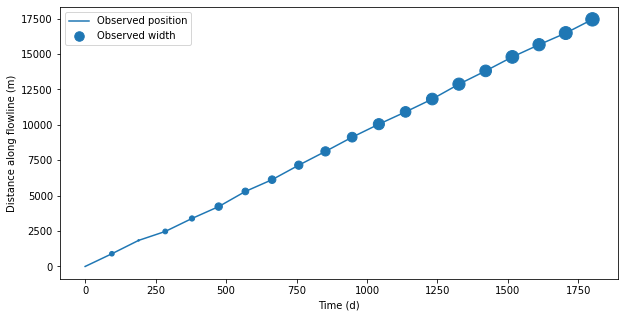

In [0]:
n = 20 #number of iterations
v = 10 # Ice velocity (m/d)
dw = 0.01 # Rift widening rate (per day)
dt = 90 # observation repeat interval in days
t = np.linspace(0,n*dt,n)
obs = np.zeros((n,3))

for i in range(0, n):
  obs[i,0] = np.random.randn() # x position
 
  # y position
  if i == 0:
    obs[i,1] = np.random.randn() 
  else:
    obs[i,1] = obs[i-1,1] + dt*v + 100*np.random.randn()

  obs[i,2] = dw*t[i] + np.random.randn()

fig=plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
plt.plot(t,obs[:,1],label='Observed position')
plt.scatter(t,obs[:,1],10*obs[:,2],label='Observed width')
fig.patch.set_facecolor('white')
ax.legend()
plt.xlabel('Time (d)')
plt.ylabel('Distance along flowline (m)')

Step 2. Set up the Kalman Filter

In [0]:
kf = KalmanFilter(dim_x=4, dim_z=3)

# Initial state estimate.   Note the dimensions of the state vector:
#    x position, y position, width, bias (to add linear offset)
kf.x = np.array( [0., 0., 1., 1.])  
kf.P *= 1 # Initial covariance

#State transition matrix
kf.F = np.identity(4)
kf.F[1,3] = v
kf.F[2,3] = dw

kf.R = 1 # measurement uncertainty/noise
kf.Q = Q_discrete_white_noise(dim=4, dt=0.1, var=0.13) # process covariance
kf.H = np.array([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,0.]])

Step 3. Assimilate the data using the Kalman Filter

Text(0, 0.5, 'Distance along flowline (m)')

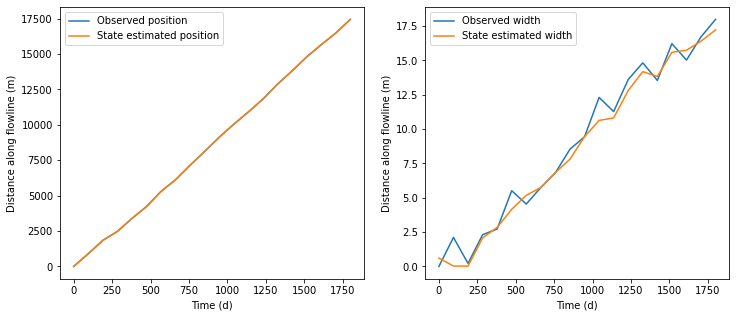

In [0]:
# Estimate position y and width w
y = np.zeros((n,1))
w = np.zeros(y.shape)
sig_y = np.zeros(y.shape)
sig_w = np.zeros(y.shape)

for i in range(0, n):
  kf.predict()
  kf.update(obs[i,])
  y[i] = kf.x[1]
  w[i] = kf.x[2]
  sig_y[i] = kf.P[1,1]
  sig_w[i] = kf.P[2,2]

fig=plt.figure(figsize=(12,5))
ax = plt.subplot(121)
plt.plot(t,obs[:,1],label='Observed position')
plt.plot(t,y,label='State estimated position')
fig.patch.set_facecolor('white')
ax.legend()
plt.xlabel('Time (d)')
plt.ylabel('Distance along flowline (m)')
ax = plt.subplot(122)
plt.plot(t,obs[:,2],label='Observed width')
plt.plot(t,w,label='State estimated width')
fig.patch.set_facecolor('white')
ax.legend()
plt.xlabel('Time (d)')
plt.ylabel('Distance along flowline (m)')


In [0]:
kf.Q

array([[3.61111111e-09, 1.08333333e-07, 2.16666667e-06, 2.16666667e-05],
       [1.08333333e-07, 3.25000000e-06, 6.50000000e-05, 6.50000000e-04],
       [2.16666667e-06, 6.50000000e-05, 1.30000000e-03, 1.30000000e-02],
       [2.16666667e-05, 6.50000000e-04, 1.30000000e-02, 1.30000000e-01]])